In [1]:
import csv
import re
import typing as t
from collections import defaultdict
from pathlib import Path

import nltk
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import stopwords, wordnet
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from tqdm import tqdm

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
DATA_DIR = Path("data/")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE.upper()} device")

Using CUDA device


In [4]:
def on_cuda(device: str) -> bool:
    return device == "cuda"


def common_train(
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        train_dataloader: DataLoader,
        epochs: int,
        test_dataloader: DataLoader = None,
        lr_scheduler=None,
        verbose: int = 100,
        device: str = "cpu",
) -> t.List[float]:
    train_losses = []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n" + "-" * 32)
        train_loss = train_loop(
            train_dataloader,
            model,
            loss_fn,
            optimizer,
            verbose=verbose,
            device=device,
        )
        train_losses.append(train_loss.item())
        if test_dataloader:
            loss, acc = test_loop(test_dataloader, model, loss_fn, device=device)
            if lr_scheduler:
                lr_scheduler.step(loss)
        torch.cuda.empty_cache()
    return train_losses


def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = 100,
        device: str = "cpu",
) -> torch.Tensor:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss = 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        avg_loss += loss
        if batch % verbose == 0:
            print(f"loss: {loss:>7f}  [{batch * len(x):>5d}/{size:>5d}]")

        del x, y, pred, loss
        torch.cuda.empty_cache()

    return avg_loss / num_batches


@torch.no_grad()
def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        device: str = "cpu",
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, correct = 0, 0

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        avg_loss += loss_fn(pred, y)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()  # noqa

        del x, y, pred
        torch.cuda.empty_cache()

    avg_loss /= num_batches
    accuracy = correct / size
    print(f"Test Error: \n Accuracy: {accuracy:>4f}, Avg loss: {avg_loss:>8f} \n")

    return avg_loss, accuracy


def train_test_split(dataset: t.Union[Dataset, t.Sized], train_part: float) -> t.Tuple[Subset, Subset]:
    train_size = round(train_part * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, lengths=(train_size, test_size))
    return train_dataset, test_dataset


@torch.no_grad()
def get_y_test_y_pred(
        model: nn.Module,
        test_dataloader: DataLoader,
        device: str = "cpu",
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    y_test = []
    y_pred = []
    for x, y in test_dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x).argmax(1)
        y_test.append(y)
        y_pred.append(pred)

        del x
        torch.cuda.empty_cache()

    return torch.hstack(y_test).detach().cpu(), torch.hstack(y_pred).detach().cpu()

## 1. Классификация фамилий (RNN)

Датасет: https://disk.yandex.ru/d/frNchuaBQVLxyA?w=1

1.1 Используя класс `nn.RNNCell` (абстракцию для отдельного временного шага RNN), реализуйте простейшую рекуррентную сеть Элмана в виде класса `RNN`. Используя созданный класс `RNN`, решите задачу классификации фамилий. 


In [5]:
class RNN(nn.Module):

    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)

    def forward(self, inputs: torch.Tensor, hx: torch.Tensor = None):
        batch_size, sequence_size, _ = inputs.size()
        inputs = inputs.permute(1, 0, 2)  # для nn.RNNCell batch_size должен быть на 2-ой месте

        if hx is None:
            # так же скрытое состояние инициализируется в nn.RNN
            hx = torch.zeros(batch_size, self.hidden_size, dtype=inputs.dtype, device=inputs.device)
        else:
            # 1-ая размерность равная 1 для совместимости с nn.RNN
            hx = hx.squeeze(0)  # избавляемся от 1-ой размерности равной 1

        hidden = []
        for i in range(sequence_size):
            hx = self.rnn_cell(inputs[i], hx)
            hidden.append(hx)

        hidden = torch.stack(hidden)
        hx = hidden[-1].unsqueeze(0)
        return hidden.permute(1, 0, 2), hx

Проверка реализации RNN:

In [6]:
torch.manual_seed(0)

input_size, hidden_size = 4, 5
inputs = torch.randn(2, 3, input_size)
hx = torch.randn(1, 2, hidden_size)

torch.manual_seed(0)
my_rnn = RNN(input_size=input_size, hidden_size=hidden_size)

torch.manual_seed(0)
true_rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)

In [7]:
my_rnn(inputs, hx)

(tensor([[[ 0.6515,  0.5430,  0.4023,  0.6325, -0.6068],
          [ 0.9149, -0.1088,  0.6385, -0.7387,  0.7532],
          [-0.6936,  0.5123, -0.2784, -0.5693, -0.0055]],
 
         [[ 0.1954,  0.6152,  0.2958, -0.8005,  0.8074],
          [-0.4577,  0.7566,  0.2972, -0.8834,  0.1265],
          [ 0.7166,  0.1516,  0.8047, -0.2007,  0.8192]]],
        grad_fn=<PermuteBackward>),
 tensor([[[-0.6936,  0.5123, -0.2784, -0.5693, -0.0055],
          [ 0.7166,  0.1516,  0.8047, -0.2007,  0.8192]]],
        grad_fn=<UnsqueezeBackward0>))

In [8]:
true_rnn(inputs, hx)

(tensor([[[ 0.6515,  0.5430,  0.4023,  0.6325, -0.6068],
          [ 0.9149, -0.1088,  0.6385, -0.7387,  0.7532],
          [-0.6936,  0.5123, -0.2784, -0.5693, -0.0055]],
 
         [[ 0.1954,  0.6152,  0.2958, -0.8005,  0.8074],
          [-0.4577,  0.7566,  0.2972, -0.8834,  0.1265],
          [ 0.7166,  0.1516,  0.8047, -0.2007,  0.8192]]],
        grad_fn=<TransposeBackward1>),
 tensor([[[-0.6936,  0.5123, -0.2784, -0.5693, -0.0055],
          [ 0.7166,  0.1516,  0.8047, -0.2007,  0.8192]]],
        grad_fn=<StackBackward>))

100% совпадение

In [9]:
class SurnamesRNNClassifier(nn.Module):

    def __init__(
            self,
            num_embeddings: int,
            embedding_dim: int,
            rnn_hidden_size: int,
            vector_size: int,
            num_classes: int,
    ):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim, padding_idx=0)
        self.rnn = RNN(input_size=embedding_dim, hidden_size=rnn_hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(rnn_hidden_size * vector_size, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)
        x, hx = self.rnn(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

In [10]:
class SurnamesVocab:
    pad = "<PAD>"

    def __init__(self, surnames: t.List[str]):
        uniques = set()
        max_len = 0
        for w in map(str.lower, surnames):
            uniques.update(w)
            max_len = max(len(w), max_len)

        self.alphabet = [self.pad, *uniques]
        self.max_len = max_len
        self.ch2i = {ch: i for i, ch in enumerate(self.alphabet)}

    def __len__(self):
        return len(self.alphabet)

    def encode(self, word: str) -> torch.Tensor:
        indices = [self.ch2i[ch] for ch in word]
        indices += [self.ch2i[self.pad]] * (self.max_len - len(indices))
        return torch.tensor(indices, dtype=torch.long)

    def decode(self, indices: torch.Tensor) -> str:
        pad_indices = torch.nonzero(indices == self.ch2i[self.pad], as_tuple=True)[0]
        if len(pad_indices):
            indices = indices[:pad_indices[0]]
        return "".join(self.alphabet[i] for i in indices)


class SurnamesDataset(Dataset):
    df: pd.DataFrame
    surnames: t.List[str]
    vocab: SurnamesVocab
    labeler: LabelEncoder
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, path: Path):
        self.df = pd.read_csv(path)

        self.surnames = self.df["surname"].tolist()
        self.vocab = SurnamesVocab(self.surnames)
        size = self.vocab.encode(self.surnames[0].lower()).size()
        data = torch.vstack([self.vocab.encode(w.lower()) for w in self.surnames])
        self.data = data.view(len(self.surnames), *size)

        self.labeler = LabelEncoder()
        targets = self.labeler.fit_transform(self.df["nationality"])
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def encode(self, word: str) -> torch.Tensor:
        return self.vocab.encode(word)

    def decode(self, indices: torch.Tensor) -> str:
        return self.vocab.decode(indices)

In [11]:
surnames_dataset = SurnamesDataset(DATA_DIR / "surnames.csv")
len(surnames_dataset)

10980

In [12]:
torch.manual_seed(0)

train_surnames_dataset, test_surnames_dataset = train_test_split(surnames_dataset, train_part=0.8)
print(len(train_surnames_dataset), len(test_surnames_dataset))

8784 2196


### Handmade RNN

In [13]:
torch.manual_seed(0)

handmade_rnn_net = SurnamesRNNClassifier(
    num_embeddings=len(surnames_dataset.vocab),
    embedding_dim=128,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(handmade_rnn_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [14]:
%%time

_ = common_train(
    epochs=20,
    model=handmade_rnn_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.887971  [    0/ 8784]
loss: 1.460474  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.624317, Avg loss: 1.268815 

Epoch 2
--------------------------------
loss: 1.189004  [    0/ 8784]
loss: 1.210896  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.702186, Avg loss: 1.038538 

Epoch 3
--------------------------------
loss: 0.907800  [    0/ 8784]
loss: 0.862654  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.729964, Avg loss: 0.954668 

Epoch 4
--------------------------------
loss: 0.843660  [    0/ 8784]
loss: 0.842537  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.738616, Avg loss: 0.897260 

Epoch 5
--------------------------------
loss: 0.711590  [    0/ 8784]
loss: 0.976198  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.745446, Avg loss: 0.872289 

Epoch 6
--------------------------------
loss: 0.699940  [    0/ 8784]
loss: 0.559541  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.746357, Avg loss: 0.865911 

Epoch 7
--------------------------------
loss: 0.530410  [    0/

In [15]:
y_test, y_pred = get_y_test_y_pred(handmade_rnn_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.96      1.00      0.98       340
     Chinese       0.68      0.74      0.71        38
       Czech       0.61      0.34      0.44        96
       Dutch       0.73      0.43      0.54        51
     English       0.69      0.87      0.77       573
      French       0.14      0.05      0.08        39
      German       0.53      0.52      0.52       121
       Greek       0.79      0.56      0.66        34
       Irish       0.86      0.32      0.47        37
     Italian       0.70      0.68      0.69       128
    Japanese       0.88      0.85      0.86       156
      Korean       0.20      0.20      0.20        10
      Polish       0.56      0.38      0.45        26
  Portuguese       0.00      0.00      0.00         9
     Russian       0.85      0.86      0.86       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.44      0.40      0.42        50
  Vietnamese       0.50    

1.2 Замените модуль `RNN` из 1.1 на модули `nn.RNN`, `nn.LSTM` и `nn.GRU` (не забудьте указать аргумент `batch_first=True`). Сравните результаты работы.

In [16]:
class SurnamesAutobotRNNClassifier(nn.Module):

    def __init__(
            self,
            rnn_cls: t.Union[t.Type[nn.RNN], t.Type[nn.LSTM], t.Type[nn.GRU]],
            num_embeddings: int,
            embedding_dim: int,
            rnn_hidden_size: int,
            vector_size: int,
            num_classes: int,
    ):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim, padding_idx=0)
        self.hx, self.cx = None, None
        self.rnn = rnn_cls(input_size=embedding_dim, hidden_size=rnn_hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(rnn_hidden_size * vector_size, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)

        if isinstance(self.rnn, (nn.RNN, nn.GRU)):
            x, hx = self.rnn(x, self.hx)
            self.hx = hx.detach()
        else:
            if self.hx is not None and self.cx is not None:
                hx_cx = (self.hx, self.cx)
            else:
                hx_cx = None
            x, (hx, cx) = self.rnn(x, hx_cx)
            self.cx = cx.detach()
            self.hx = hx.detach()

        x = torch.flatten(x, 1)
        return self.classifier(x)

### nn.RNN

In [17]:
torch.manual_seed(0)

rnn_net = SurnamesAutobotRNNClassifier(
    rnn_cls=nn.RNN,
    num_embeddings=len(surnames_dataset.vocab),
    embedding_dim=128,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [18]:
%%time

_ = common_train(
    epochs=20,
    model=rnn_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.874605  [    0/ 8784]
loss: 1.633806  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.579690, Avg loss: 1.431513 

Epoch 2
--------------------------------
loss: 1.352032  [    0/ 8784]
loss: 1.319001  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.653916, Avg loss: 1.206944 

Epoch 3
--------------------------------
loss: 1.082676  [    0/ 8784]
loss: 1.019523  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.676685, Avg loss: 1.106101 

Epoch 4
--------------------------------
loss: 1.002640  [    0/ 8784]
loss: 0.959590  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.703097, Avg loss: 1.016859 

Epoch 5
--------------------------------
loss: 0.918670  [    0/ 8784]
loss: 1.060783  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.712204, Avg loss: 0.989125 

Epoch 6
--------------------------------
loss: 0.896251  [    0/ 8784]
loss: 0.856330  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.722222, Avg loss: 0.961450 

Epoch 7
--------------------------------
loss: 0.572283  [    0/

In [19]:
y_test, y_pred = get_y_test_y_pred(rnn_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.97      1.00      0.98       340
     Chinese       0.74      0.84      0.79        38
       Czech       0.49      0.26      0.34        96
       Dutch       0.76      0.37      0.50        51
     English       0.68      0.87      0.76       573
      French       0.07      0.03      0.04        39
      German       0.58      0.46      0.52       121
       Greek       0.70      0.41      0.52        34
       Irish       0.67      0.27      0.38        37
     Italian       0.63      0.76      0.69       128
    Japanese       0.86      0.82      0.84       156
      Korean       0.29      0.20      0.24        10
      Polish       0.60      0.46      0.52        26
  Portuguese       0.00      0.00      0.00         9
     Russian       0.84      0.87      0.86       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.44      0.34      0.38        50
  Vietnamese       0.50    

### nn.LSTM

In [20]:
torch.manual_seed(0)

lstm_net = SurnamesAutobotRNNClassifier(
    rnn_cls=nn.LSTM,
    num_embeddings=len(surnames_dataset.vocab),
    embedding_dim=128,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [21]:
%%time

_ = common_train(
    epochs=20,
    model=lstm_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.880923  [    0/ 8784]
loss: 1.884630  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.547814, Avg loss: 1.564271 

Epoch 2
--------------------------------
loss: 1.436014  [    0/ 8784]
loss: 1.586476  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.620674, Avg loss: 1.314317 

Epoch 3
--------------------------------
loss: 1.358808  [    0/ 8784]
loss: 1.247718  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.664390, Avg loss: 1.162704 

Epoch 4
--------------------------------
loss: 1.049469  [    0/ 8784]
loss: 1.096033  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.678051, Avg loss: 1.092257 

Epoch 5
--------------------------------
loss: 1.062434  [    0/ 8784]
loss: 0.901455  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.691712, Avg loss: 1.025694 

Epoch 6
--------------------------------
loss: 1.024183  [    0/ 8784]
loss: 0.912489  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.709016, Avg loss: 0.982719 

Epoch 7
--------------------------------
loss: 0.820191  [    0/

In [22]:
y_test, y_pred = get_y_test_y_pred(lstm_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.98      1.00      0.99       340
     Chinese       0.73      0.71      0.72        38
       Czech       0.57      0.24      0.34        96
       Dutch       0.68      0.33      0.45        51
     English       0.67      0.88      0.76       573
      French       0.10      0.03      0.04        39
      German       0.53      0.42      0.47       121
       Greek       0.68      0.50      0.58        34
       Irish       0.67      0.22      0.33        37
     Italian       0.64      0.72      0.68       128
    Japanese       0.85      0.85      0.85       156
      Korean       0.18      0.20      0.19        10
      Polish       0.45      0.38      0.42        26
  Portuguese       0.00      0.00      0.00         9
     Russian       0.84      0.86      0.85       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.44      0.40      0.42        50
  Vietnamese       0.25    

### nn.GRU

In [23]:
torch.manual_seed(0)

gru_net = SurnamesAutobotRNNClassifier(
    rnn_cls=nn.GRU,
    num_embeddings=len(surnames_dataset.vocab),
    embedding_dim=128,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [24]:
%%time

_ = common_train(
    epochs=20,
    model=gru_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.884707  [    0/ 8784]
loss: 1.712844  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.561931, Avg loss: 1.529570 

Epoch 2
--------------------------------
loss: 1.658825  [    0/ 8784]
loss: 1.210827  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.627505, Avg loss: 1.270196 

Epoch 3
--------------------------------
loss: 1.240748  [    0/ 8784]
loss: 1.252751  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.666211, Avg loss: 1.150547 

Epoch 4
--------------------------------
loss: 1.150284  [    0/ 8784]
loss: 0.970849  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.683971, Avg loss: 1.071097 

Epoch 5
--------------------------------
loss: 1.060233  [    0/ 8784]
loss: 0.920568  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.696266, Avg loss: 1.013802 

Epoch 6
--------------------------------
loss: 0.853729  [    0/ 8784]
loss: 0.756440  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.721767, Avg loss: 0.962099 

Epoch 7
--------------------------------
loss: 0.766743  [    0/

In [25]:
y_test, y_pred = get_y_test_y_pred(gru_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.95      1.00      0.97       340
     Chinese       0.77      0.61      0.68        38
       Czech       0.53      0.25      0.34        96
       Dutch       0.75      0.29      0.42        51
     English       0.67      0.87      0.75       573
      French       0.13      0.08      0.10        39
      German       0.64      0.34      0.44       121
       Greek       0.65      0.44      0.53        34
       Irish       0.58      0.19      0.29        37
     Italian       0.63      0.75      0.68       128
    Japanese       0.86      0.87      0.86       156
      Korean       0.21      0.30      0.25        10
      Polish       0.50      0.35      0.41        26
  Portuguese       0.00      0.00      0.00         9
     Russian       0.83      0.88      0.86       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.46      0.32      0.38        50
  Vietnamese       0.33    

1.3 Загрузите предобученные эмбеддинги (https://disk.yandex.ru/d/BHuT2tEXr_yBOQ?w=1) в модуль `nn.Embedding` и обучите модели из 1.2.

In [26]:
class SurnamesDecepticonRNNClassifier(nn.Module):

    def __init__(
            self,
            embedding: nn.Embedding,
            rnn_cls: t.Union[t.Type[nn.RNN], t.Type[nn.LSTM], t.Type[nn.GRU]],
            rnn_hidden_size: int,
            vector_size: int,
            num_classes: int,
    ):
        super().__init__()
        self.embedding = embedding
        self.hx, self.cx = None, None
        self.rnn = rnn_cls(input_size=self.embedding.embedding_dim, hidden_size=rnn_hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(rnn_hidden_size * vector_size, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )

    def reset_rnn_state(self):
        self.hx, self.cx = None, None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)

        if isinstance(self.rnn, (nn.RNN, nn.GRU)):
            x, hx = self.rnn(x, self.hx)
            self.hx = hx.detach()
        else:
            if self.hx is not None and self.cx is not None:
                hx_cx = (self.hx, self.cx)
            else:
                hx_cx = None
            x, (hx, cx) = self.rnn(x, hx_cx)
            self.hx = hx.detach()
            self.cx = cx.detach()

        x = torch.flatten(x, 1)
        return self.classifier(x)

In [27]:
torch.manual_seed(0)

embedding_weights = pd.read_csv(
    DATA_DIR / "glove.6B/glove.6B.50d.txt",
    sep=" ",
    quoting=csv.QUOTE_NONE,
    index_col=0,
    header=None,
)

weights = torch.ones(len(surnames_dataset.vocab), embedding_weights.shape[1], dtype=torch.float32)
torch.nn.init.normal_(weights)

miss = 0
for i, ch in enumerate(surnames_dataset.vocab.alphabet):
    try:
        weights[i] = torch.from_numpy(embedding_weights.loc[ch].to_numpy())
    except KeyError:
        miss += 1

embedding = nn.Embedding.from_pretrained(weights, padding_idx=0)
embedding, miss

(Embedding(56, 50, padding_idx=0), 5)

### nn.RNN

In [28]:
torch.manual_seed(0)

rnn_net = SurnamesDecepticonRNNClassifier(
    embedding=embedding,
    rnn_cls=nn.RNN,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [29]:
%%time

_ = common_train(
    epochs=20,
    model=rnn_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.844056  [    0/ 8784]
loss: 1.961480  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.469035, Avg loss: 1.821727 

Epoch 2
--------------------------------
loss: 1.777585  [    0/ 8784]
loss: 1.709133  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.547359, Avg loss: 1.581834 

Epoch 3
--------------------------------
loss: 1.588760  [    0/ 8784]
loss: 1.549079  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.586066, Avg loss: 1.437853 

Epoch 4
--------------------------------
loss: 1.450417  [    0/ 8784]
loss: 1.257675  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.623406, Avg loss: 1.310767 

Epoch 5
--------------------------------
loss: 1.038258  [    0/ 8784]
loss: 1.278656  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.653005, Avg loss: 1.219411 

Epoch 6
--------------------------------
loss: 1.158547  [    0/ 8784]
loss: 1.452169  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.666211, Avg loss: 1.178816 

Epoch 7
--------------------------------
loss: 0.991674  [    0/

In [30]:
y_test, y_pred = get_y_test_y_pred(rnn_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.93      1.00      0.96       340
     Chinese       0.66      0.87      0.75        38
       Czech       0.67      0.21      0.32        96
       Dutch       0.67      0.24      0.35        51
     English       0.63      0.91      0.74       573
      French       0.12      0.05      0.07        39
      German       0.65      0.26      0.38       121
       Greek       0.62      0.47      0.53        34
       Irish       0.75      0.24      0.37        37
     Italian       0.62      0.72      0.67       128
    Japanese       0.79      0.85      0.82       156
      Korean       0.17      0.10      0.12        10
      Polish       0.62      0.38      0.48        26
  Portuguese       0.00      0.00      0.00         9
     Russian       0.87      0.82      0.84       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.50      0.22      0.31        50
  Vietnamese       1.00    

### nn.LSTM

In [31]:
torch.manual_seed(0)

lstm_net = SurnamesDecepticonRNNClassifier(
    embedding=embedding,
    rnn_cls=nn.LSTM,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [32]:
%%time

_ = common_train(
    epochs=20,
    model=lstm_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.900342  [    0/ 8784]
loss: 2.214212  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.426230, Avg loss: 1.955202 

Epoch 2
--------------------------------
loss: 2.063104  [    0/ 8784]
loss: 1.851924  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.525046, Avg loss: 1.633425 

Epoch 3
--------------------------------
loss: 1.751783  [    0/ 8784]
loss: 1.601672  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.573770, Avg loss: 1.469063 

Epoch 4
--------------------------------
loss: 1.500901  [    0/ 8784]
loss: 1.434251  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.619308, Avg loss: 1.329760 

Epoch 5
--------------------------------
loss: 1.145660  [    0/ 8784]
loss: 1.335644  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.651639, Avg loss: 1.240957 

Epoch 6
--------------------------------
loss: 1.202477  [    0/ 8784]
loss: 1.068419  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.664390, Avg loss: 1.145671 

Epoch 7
--------------------------------
loss: 0.915265  [    0/

In [33]:
y_test, y_pred = get_y_test_y_pred(lstm_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.96      1.00      0.98       340
     Chinese       0.67      0.82      0.74        38
       Czech       0.43      0.22      0.29        96
       Dutch       0.78      0.35      0.49        51
     English       0.65      0.90      0.76       573
      French       0.17      0.05      0.08        39
      German       0.55      0.40      0.46       121
       Greek       0.64      0.41      0.50        34
       Irish       0.75      0.24      0.37        37
     Italian       0.70      0.67      0.69       128
    Japanese       0.86      0.83      0.84       156
      Korean       0.38      0.30      0.33        10
      Polish       0.53      0.35      0.42        26
  Portuguese       1.00      0.00      0.00         9
     Russian       0.84      0.84      0.84       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.57      0.34      0.42        50
  Vietnamese       0.50    

### nn.GRU

In [34]:
torch.manual_seed(0)

gru_net = SurnamesDecepticonRNNClassifier(
    embedding=embedding,
    rnn_cls=nn.GRU,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [35]:
%%time

_ = common_train(
    epochs=20,
    model=gru_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.875406  [    0/ 8784]
loss: 1.869805  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.448543, Avg loss: 1.893556 

Epoch 2
--------------------------------
loss: 1.731786  [    0/ 8784]
loss: 1.537178  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.535974, Avg loss: 1.590274 

Epoch 3
--------------------------------
loss: 1.372517  [    0/ 8784]
loss: 1.425336  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.592896, Avg loss: 1.427738 

Epoch 4
--------------------------------
loss: 1.198495  [    0/ 8784]
loss: 1.435925  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.628415, Avg loss: 1.295024 

Epoch 5
--------------------------------
loss: 1.276708  [    0/ 8784]
loss: 1.447090  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.647996, Avg loss: 1.209272 

Epoch 6
--------------------------------
loss: 1.390478  [    0/ 8784]
loss: 1.374148  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.670310, Avg loss: 1.142552 

Epoch 7
--------------------------------
loss: 1.004989  [    0/

In [36]:
y_test, y_pred = get_y_test_y_pred(gru_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.94      1.00      0.97       340
     Chinese       0.72      0.74      0.73        38
       Czech       0.53      0.18      0.27        96
       Dutch       0.62      0.39      0.48        51
     English       0.65      0.91      0.76       573
      French       0.14      0.03      0.04        39
      German       0.65      0.32      0.43       121
       Greek       0.55      0.47      0.51        34
       Irish       0.83      0.27      0.41        37
     Italian       0.62      0.77      0.69       128
    Japanese       0.78      0.87      0.82       156
      Korean       0.25      0.30      0.27        10
      Polish       0.45      0.35      0.39        26
  Portuguese       0.00      0.00      0.00         9
     Russian       0.89      0.81      0.85       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.39      0.24      0.30        50
  Vietnamese       1.00    

## 2. Классификация новостей на основе заголовка

Датасет: https://disk.yandex.ru/d/FN-EgWGIpyjLxQ?w=1

Эмбеддинги: https://nlp.stanford.edu/projects/glove/ (находите ссылку на архив
glove.6B.zip, в нем несколько файлов с эмбеддингами слов, выбираете один из файлов в
архиве)

2.1 Загрузите набор данных train.csv. Выполните предобработку столбца Title

2.2 На основе этих данных создайте датасет NewsDataset . Не забудьте добавить
специальные токены `<PAD>` для дополнения последовательностей до нужной длины и
`<UNK>` для корректной обработке ранее не встречавшихся токенов. В данной задаче
рассматривайте отдельные слова как токены. Разбейте датасет на обучающее и
валидационное множество.

In [37]:
PATTERN = re.compile(r"[^a-z]", flags=re.MULTILINE)
STOPWORDS = set(stopwords.words("english"))


def simple_preprocess_news_title(title: str) -> str:
    return title.lower()


def complex_preprocess_news_title(
        title: str,
        lemmatizer_or_stemmer: t.Callable[[str], str] = None,
        min_word_len: int = 0,
) -> str:
    title = simple_preprocess_news_title(title)
    title = PATTERN.sub(" ", title)

    words = []
    for word in nltk.word_tokenize(title):
        if word not in STOPWORDS and len(word) >= min_word_len:
            if not lemmatizer_or_stemmer:
                words.append(word)
                continue
            word = lemmatizer_or_stemmer(word)
            if word not in STOPWORDS and len(word) >= min_word_len:
                words.append(word)

    return " ".join(words)

In [38]:
def get_pos(word: str) -> str:
    tag = nltk.pos_tag([word])[0][1]
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


_wordnet_lemmatizer = nltk.WordNetLemmatizer()


def wordnet_lemmatizer(token: str) -> str:
    return _wordnet_lemmatizer.lemmatize(token, pos=get_pos(token))


_snowball_stemmer = nltk.SnowballStemmer(language="english")


def snowball_stemmer(token: str) -> str:
    return _snowball_stemmer.stem(token)

In [39]:
class NewsVocab:
    pad = "<PAD>"
    unknown = "<UNK>"

    def __init__(self, news_titles: t.List[str], max_len: int = 0):
        uniques = set()
        for title in news_titles:
            words = nltk.word_tokenize(title)
            uniques.update(words)
            max_len = max(len(words), max_len)

        self.alphabet = [self.pad, self.unknown, *uniques]
        self.max_len = max_len

        w2i = {w: i for i, w in enumerate(self.alphabet)}
        unknown_idx = w2i[self.unknown]
        self.w2i = defaultdict(lambda: unknown_idx, w2i)

    def __len__(self):
        return len(self.alphabet)

    def encode(self, review: str) -> torch.Tensor:
        indices = [self.w2i[w] for w in nltk.word_tokenize(review)]
        indices += [self.w2i[self.pad]] * (self.max_len - len(indices))
        return torch.tensor(indices, dtype=torch.long)

    def decode(self, indices: torch.Tensor) -> str:
        pad_indices = torch.nonzero(indices == self.w2i[self.pad], as_tuple=True)[0]  # noqa
        if len(pad_indices):
            indices = indices[:pad_indices[0]]
        return " ".join(self.alphabet[i] for i in indices)


class NewsDataset(Dataset):
    df: pd.DataFrame
    titles: t.List[str]
    classes: t.List[int]
    vocab: NewsVocab
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, path: Path, preprocess: t.Callable[[str], str], title_max_len: int = 0):
        self.df = pd.read_csv(path)

        self.titles = self.df["Title"].apply(preprocess).tolist()
        self.vocab = NewsVocab(self.titles, max_len=title_max_len)

        self.data = torch.vstack([self.vocab.encode(w.lower()) for w in self.titles])
        self.targets = torch.tensor(self.df["Class Index"].to_numpy(), dtype=torch.long) - 1
        self.classes = self.targets.unique().tolist()

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def encode(self, title: str) -> torch.Tensor:
        return self.vocab.encode(title)

    def decode(self, indices: torch.Tensor) -> str:
        return self.vocab.decode(indices)

In [40]:
def preprocess_news_title(title: str) -> str:
    return complex_preprocess_news_title(title, lemmatizer_or_stemmer=snowball_stemmer, min_word_len=3)


train_news_dataset = NewsDataset(
    DATA_DIR / "news/train.csv",
    preprocess_news_title,
)
test_news_dataset = NewsDataset(
    DATA_DIR / "news/test.csv",
    preprocess_news_title,
    title_max_len=train_news_dataset.vocab.max_len,
)
len(train_news_dataset), len(test_news_dataset)

(120000, 7600)

In [41]:
train_news_dataloader = DataLoader(train_news_dataset, batch_size=256, shuffle=True)
test_news_dataloader = DataLoader(test_news_dataset, batch_size=512)

2.3 Создайте модель для классификации, используя слой nn.Embedding и слой nn.RNN.
эмбеддинги инициализируйте случайным образом не забудьте указать аргумент padding_idx для nn.Embedding

In [42]:
class NewsClassifier(nn.Module):

    def __init__(
            self,
            embedding: nn.Embedding,
            rnn_cls: t.Union[t.Type[nn.RNN], t.Type[nn.LSTM], t.Type[nn.GRU]],
            rnn_hidden_size: int,
            vector_size: int,
            num_classes: int,
    ):
        super().__init__()
        self.embedding = embedding
        self.hx, self.cx = None, None
        self.rnn = rnn_cls(input_size=self.embedding.embedding_dim, hidden_size=rnn_hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(rnn_hidden_size * vector_size, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )

    def reset_rnn_state(self):
        self.hx, self.cx = None, None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)

        if isinstance(self.rnn, (nn.RNN, nn.GRU)):
            x, hx = self.rnn(x, self.hx)
            self.hx = hx.detach()
        else:
            if self.hx is not None and self.cx is not None:
                hx_cx = (self.hx, self.cx)
            else:
                hx_cx = None
            x, (hx, cx) = self.rnn(x, hx_cx)
            self.hx = hx.detach()
            self.cx = cx.detach()

        x = torch.flatten(x, 1)
        return self.classifier(x)

In [43]:
torch.manual_seed(0)

news_rnn_net = NewsClassifier(
    embedding=nn.Embedding(num_embeddings=len(train_news_dataset.vocab), embedding_dim=64, padding_idx=0),
    rnn_cls=nn.RNN,
    rnn_hidden_size=64,
    vector_size=train_news_dataset.vocab.max_len,
    num_classes=len(train_news_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(news_rnn_net.parameters(), lr=0.001)

In [44]:
%%time

_ = common_train(
    epochs=5,
    model=news_rnn_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_news_dataloader,
    test_dataloader=test_news_dataloader,
    verbose=400,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 1.398488  [    0/120000]
loss: 0.775554  [102400/120000]
Test Error: 
 Accuracy: 0.245658, Avg loss: 1.825695 

Epoch 2
--------------------------------
loss: 0.829722  [    0/120000]
loss: 0.577932  [102400/120000]
Test Error: 
 Accuracy: 0.243289, Avg loss: 2.134828 

Epoch 3
--------------------------------
loss: 0.540253  [    0/120000]
loss: 0.577653  [102400/120000]
Test Error: 
 Accuracy: 0.242368, Avg loss: 2.230031 

Epoch 4
--------------------------------
loss: 0.459172  [    0/120000]
loss: 0.345430  [102400/120000]
Test Error: 
 Accuracy: 0.242632, Avg loss: 2.448734 

Epoch 5
--------------------------------
loss: 0.330366  [    0/120000]
loss: 0.426021  [102400/120000]
Test Error: 
 Accuracy: 0.241974, Avg loss: 2.801781 

CPU times: user 38.8 s, sys: 6.67 s, total: 45.5 s
Wall time: 46.9 s


2.4 Переобучите модель, заменив слой nn.RNN на nn.LSTM и nn.GRU . Сравните качество
на тестовой выборке. Результаты сведите в таблицу (модель/метрика качества на тестовом множестве).

In [45]:
torch.manual_seed(0)

news_lstm_net = NewsClassifier(
    embedding=nn.Embedding(num_embeddings=len(train_news_dataset.vocab), embedding_dim=64, padding_idx=0),
    rnn_cls=nn.LSTM,
    rnn_hidden_size=64,
    vector_size=train_news_dataset.vocab.max_len,
    num_classes=len(train_news_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(news_lstm_net.parameters(), lr=0.001)

In [46]:
%%time

_ = common_train(
    epochs=5,
    model=news_lstm_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_news_dataloader,
    test_dataloader=test_news_dataloader,
    verbose=400,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 1.386017  [    0/120000]
loss: 0.583580  [102400/120000]
Test Error: 
 Accuracy: 0.248553, Avg loss: 1.786926 

Epoch 2
--------------------------------
loss: 0.569937  [    0/120000]
loss: 0.514011  [102400/120000]
Test Error: 
 Accuracy: 0.245000, Avg loss: 1.993639 

Epoch 3
--------------------------------
loss: 0.450888  [    0/120000]
loss: 0.527745  [102400/120000]
Test Error: 
 Accuracy: 0.247763, Avg loss: 2.198192 

Epoch 4
--------------------------------
loss: 0.308758  [    0/120000]
loss: 0.371936  [102400/120000]
Test Error: 
 Accuracy: 0.242105, Avg loss: 2.420766 

Epoch 5
--------------------------------
loss: 0.325474  [    0/120000]
loss: 0.498787  [102400/120000]
Test Error: 
 Accuracy: 0.238553, Avg loss: 2.607911 

CPU times: user 39.2 s, sys: 6.05 s, total: 45.2 s
Wall time: 46.3 s


In [47]:
torch.manual_seed(0)

news_gru_net = NewsClassifier(
    embedding=nn.Embedding(num_embeddings=len(train_news_dataset.vocab), embedding_dim=64, padding_idx=0),
    rnn_cls=nn.GRU,
    rnn_hidden_size=64,
    vector_size=train_news_dataset.vocab.max_len,
    num_classes=len(train_news_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(news_gru_net.parameters(), lr=0.001)

In [48]:
%%time

_ = common_train(
    epochs=5,
    model=news_gru_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_news_dataloader,
    test_dataloader=test_news_dataloader,
    verbose=400,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 1.382523  [    0/120000]
loss: 0.691126  [102400/120000]
Test Error: 
 Accuracy: 0.246447, Avg loss: 1.848297 

Epoch 2
--------------------------------
loss: 0.695150  [    0/120000]
loss: 0.461607  [102400/120000]
Test Error: 
 Accuracy: 0.250132, Avg loss: 2.005425 

Epoch 3
--------------------------------
loss: 0.548943  [    0/120000]
loss: 0.419353  [102400/120000]
Test Error: 
 Accuracy: 0.249474, Avg loss: 2.167577 

Epoch 4
--------------------------------
loss: 0.424499  [    0/120000]
loss: 0.439187  [102400/120000]
Test Error: 
 Accuracy: 0.246184, Avg loss: 2.288211 

Epoch 5
--------------------------------
loss: 0.406067  [    0/120000]
loss: 0.470791  [102400/120000]
Test Error: 
 Accuracy: 0.240921, Avg loss: 2.458678 

CPU times: user 38.5 s, sys: 6.56 s, total: 45.1 s
Wall time: 46.2 s


2.5 Выполните пункты 2.3 и 2.4, используя предобученные эмбеддинги Glove.
Прокомментируйте результат.
Эмбеддинги из скачанного файла загрузите в виде двумерного тензора pretrained_embeddings.
Обратите внимание, что номер строки в этом тензоре должен соответствовать
токену (слову), имеющему такой индекс в вашем словаре.
для слов, которых нет в файле с эмбеддингами, инициализуйте эмбеддинг
случайным образом

In [49]:
torch.manual_seed(0)

embedding_weights = pd.read_csv(
    DATA_DIR / "glove.6B/glove.6B.100d.txt",
    sep=" ",
    quoting=csv.QUOTE_NONE,
    index_col=0,
    header=None,
)

weights = torch.empty(len(train_news_dataset.vocab), embedding_weights.shape[1], dtype=torch.float32)
torch.nn.init.normal_(weights)

miss = 0
for i, w in tqdm(enumerate(train_news_dataset.vocab.alphabet), total=len(train_news_dataset.vocab.alphabet)):
    try:
        weights[i] = torch.from_numpy(embedding_weights.loc[w].to_numpy())
    except KeyError:
        miss += 1

embedding = nn.Embedding.from_pretrained(weights, padding_idx=0)
embedding, miss

100%|██████████| 21963/21963 [01:49<00:00, 200.93it/s]


(Embedding(21963, 100, padding_idx=0), 6143)

In [50]:
torch.manual_seed(0)

news_rnn_pretrained_net = NewsClassifier(
    embedding=embedding,
    rnn_cls=nn.RNN,
    rnn_hidden_size=64,
    vector_size=train_news_dataset.vocab.max_len,
    num_classes=len(train_news_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(news_rnn_pretrained_net.parameters(), lr=0.001)

In [51]:
%%time

_ = common_train(
    epochs=5,
    model=news_rnn_pretrained_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_news_dataloader,
    test_dataloader=test_news_dataloader,
    verbose=400,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 1.384300  [    0/120000]
loss: 0.682494  [102400/120000]
Test Error: 
 Accuracy: 0.265263, Avg loss: 1.929394 

Epoch 2
--------------------------------
loss: 0.649540  [    0/120000]
loss: 0.538743  [102400/120000]
Test Error: 
 Accuracy: 0.274737, Avg loss: 1.981722 

Epoch 3
--------------------------------
loss: 0.636043  [    0/120000]
loss: 0.535246  [102400/120000]
Test Error: 
 Accuracy: 0.261974, Avg loss: 2.009139 

Epoch 4
--------------------------------
loss: 0.609225  [    0/120000]
loss: 0.540131  [102400/120000]
Test Error: 
 Accuracy: 0.266316, Avg loss: 2.066741 

Epoch 5
--------------------------------
loss: 0.573378  [    0/120000]
loss: 0.522352  [102400/120000]
Test Error: 
 Accuracy: 0.268421, Avg loss: 2.089403 

CPU times: user 35.8 s, sys: 3.11 s, total: 38.9 s
Wall time: 39.1 s


In [52]:
torch.manual_seed(0)

news_lstm_pretrained_net = NewsClassifier(
    embedding=embedding,
    rnn_cls=nn.LSTM,
    rnn_hidden_size=64,
    vector_size=train_news_dataset.vocab.max_len,
    num_classes=len(train_news_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(news_lstm_pretrained_net.parameters(), lr=0.001)

In [53]:
%%time

_ = common_train(
    epochs=5,
    model=news_lstm_pretrained_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_news_dataloader,
    test_dataloader=test_news_dataloader,
    verbose=400,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 1.386772  [    0/120000]
loss: 0.495739  [102400/120000]
Test Error: 
 Accuracy: 0.262895, Avg loss: 1.893308 

Epoch 2
--------------------------------
loss: 0.572895  [    0/120000]
loss: 0.439423  [102400/120000]
Test Error: 
 Accuracy: 0.265526, Avg loss: 2.153729 

Epoch 3
--------------------------------
loss: 0.331599  [    0/120000]
loss: 0.529190  [102400/120000]
Test Error: 
 Accuracy: 0.261316, Avg loss: 2.320305 

Epoch 4
--------------------------------
loss: 0.453869  [    0/120000]
loss: 0.418262  [102400/120000]
Test Error: 
 Accuracy: 0.263289, Avg loss: 2.351837 

Epoch 5
--------------------------------
loss: 0.422201  [    0/120000]
loss: 0.370544  [102400/120000]
Test Error: 
 Accuracy: 0.258158, Avg loss: 2.510423 

CPU times: user 38.2 s, sys: 3.63 s, total: 41.8 s
Wall time: 42.1 s


In [54]:
torch.manual_seed(0)

news_gru_pretrained_net = NewsClassifier(
    embedding=embedding,
    rnn_cls=nn.GRU,
    rnn_hidden_size=64,
    vector_size=train_news_dataset.vocab.max_len,
    num_classes=len(train_news_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(news_gru_pretrained_net.parameters(), lr=0.001)

In [55]:
%%time

_ = common_train(
    epochs=5,
    model=news_gru_pretrained_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_news_dataloader,
    test_dataloader=test_news_dataloader,
    verbose=400,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 1.387033  [    0/120000]
loss: 0.659489  [102400/120000]
Test Error: 
 Accuracy: 0.256842, Avg loss: 1.852312 

Epoch 2
--------------------------------
loss: 0.541958  [    0/120000]
loss: 0.521535  [102400/120000]
Test Error: 
 Accuracy: 0.260132, Avg loss: 2.023633 

Epoch 3
--------------------------------
loss: 0.472931  [    0/120000]
loss: 0.498077  [102400/120000]
Test Error: 
 Accuracy: 0.259211, Avg loss: 2.071061 

Epoch 4
--------------------------------
loss: 0.567600  [    0/120000]
loss: 0.423918  [102400/120000]
Test Error: 
 Accuracy: 0.259079, Avg loss: 2.148984 

Epoch 5
--------------------------------
loss: 0.528394  [    0/120000]
loss: 0.492820  [102400/120000]
Test Error: 
 Accuracy: 0.268816, Avg loss: 2.194674 

CPU times: user 36 s, sys: 3.79 s, total: 39.8 s
Wall time: 40.1 s


Результаты сведите в таблицу (модель/метрика качества на тестовом множестве).

In [56]:
def make_pivot_table(
        models: t.List[t.Tuple[str, NewsClassifier]],
        test_dataloader: DataLoader,
        device: str = "cpu",
) -> pd.DataFrame:
    general_report = {}
    for name, model in models:
        report = {}
        y_test, y_pred = get_y_test_y_pred(model, test_dataloader, device)
        ms = metrics.classification_report(y_test, y_pred, zero_division=True, output_dict=True)
        report["accuracy"] = ms["accuracy"]
        report["precision (w avg)"] = ms["weighted avg"]["precision"]
        report["recall (w avg)"] = ms["weighted avg"]["recall"]
        report["f1-score (w avg)"] = ms["weighted avg"]["f1-score"]
        general_report[name] = report
    return pd.DataFrame(general_report)

In [57]:
report = make_pivot_table(
    [
        ("RNN", news_rnn_net),
        ("LSTM", news_lstm_net),
        ("GRU", news_gru_net),
        ("RNN (pretrained)", news_rnn_pretrained_net),
        ("LSTM (pretrained)", news_lstm_pretrained_net),
        ("GRU (pretrained)", news_gru_pretrained_net),
    ],
    test_news_dataloader,
    DEVICE,
)
report

,RNN,LSTM,GRU,RNN (pretrained),LSTM (pretrained),GRU (pretrained)
accuracy,0.241974,0.238553,0.240921,0.268421,0.258158,0.268816
precision (w avg),0.241831,0.240686,0.242836,0.271295,0.265203,0.273612
recall (w avg),0.241974,0.238553,0.240921,0.268421,0.258158,0.268816
f1-score (w avg),0.236382,0.230627,0.236126,0.264540,0.252909,0.260767


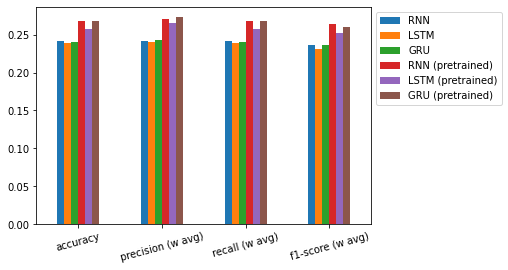

In [59]:
ax = report.plot.bar(rot=15)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1));